In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime
import xgboost as xgb
import seaborn as sns
import itertools
import xarray as xr

import sklearn.metrics
from tqdm import tqdm

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import json
from shapely.geometry import Polygon, LineString, Point

2024-09-06 15:26:04.101339: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 15:26:05.060617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
OCO2_filename = "data/formatted/OCO2_formatted.feather"

# Load datasets
OCO2_df = pd.read_feather(OCO2_filename)
OCO2_df = gpd.GeoDataFrame(
    OCO2_df, geometry=gpd.points_from_xy(OCO2_df["lon"], OCO2_df['lat'])
)

#print(df.to_string())
print("OCO2", OCO2_df.columns)


OCO2 Index(['lat', 'lon', 'datetime', 'xco2', 'hours_since_2014_1_1', 'geometry'], dtype='object')


### Pick a municipality in sweden based on the Digital RegSO borders retrievable from  

https://www.scb.se/vara-tjanster/oppna-data/oppna-geodata/regso/


In [4]:
area_name = "Lund"

filename = 'data/RegSO_2018_v2.gpkg'
commune_df = gpd.read_file(filename)
#list(set(commune_df['kommunnamn']))

commune_df = commune_df[commune_df['kommunnamn'] == "Lund"].to_crs(epsg=4326)
region_zoom = 11
save_name = "lund_with_weather.feather"

commune_df = commune_df.reset_index()
commune_df = commune_df.drop("index", axis=1)

print("Number of regions:", commune_df.shape[0])
commune_df.head()

Number of regions: 36


uuid  regsokod  \
0  D6931531-C051-4A6E-AE70-991FFCA0D655  1281R006   
1  E20393B2-9A7A-4461-AFEE-31D18E880E79  1281R007   
2  B643C9AF-B8A0-45B3-AC78-94C5F6A4E159  1281R008   
3  6CFD67A6-A925-47DC-BC51-3AE14F3C9A12  1281R009   
4  B2D6345B-C0ED-48D0-99C9-CC1B13DB6B22  1281R010   

                   kommunregso                   regso kommun kommunnamn  \
0  1281 Delphinen-Kämnärsvägen  Delphinen-Kämnärsvägen   1281       Lund   
1          1281 Genarp centrum          Genarp centrum   1281       Lund   
2          1281 Genarps omnejd          Genarps omnejd   1281       Lund   
3    1281 Kobjer-Öresundsvägen    Kobjer-Öresundsvägen   1281       Lund   
4         1281 Ladugårdsmarken         Ladugårdsmarken   1281       Lund   

   version                                           geometry  
0  2018_v2  POLYGON ((13.22493 55.72304, 13.22282 55.71941...  
1  2018_v2  POLYGON ((13.42164 55.60067, 13.42166 55.60033...  
2  2018_v2  POLYGON ((13.51062 55.57946, 13.50958 55.57954...  
3  2018_v2  POLYGON ((13.18548 55.71146, 13.18018 55.71123...  
4  2018_v2  POLYGON ((13.23949 55.73446, 13.23875 55.73400...

Filter out data that is within that municipality

In [5]:
xmin, ymin, xmax, ymax = commune_df.total_bounds
region_df = OCO2_df.cx[xmin:xmax, ymin:ymax]

commune_filter = region_df.within(commune_df.loc[0, 'geometry'])

for idx in tqdm(commune_df.index):
    commune_filter |= region_df.within(commune_df.loc[idx, 'geometry'])

print("number of polygons:", np.sum(commune_filter))

#creating a new geoDataFrame that will have only the intersecting records
region_df = region_df[commune_filter]

#resetting index(optional step if you don't need to keep the original index values)
region_df.reset_index(inplace=True, drop=True)

100%|██████████| 36/36 [00:00<00:00, 118.05it/s]

number of polygons: 1143


In [6]:
import folium

bounds = commune_df['geometry'].total_bounds

# Create a folium map centered at the bounding box
m = folium.Map(location=[(bounds[1] + bounds[3])/2, (bounds[0] + bounds[2])/2], zoom_start=region_zoom)
#m.fit_bounds(bounds)


DIM = 100000000
N = 3


for _, r in commune_df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange", 'color': 'orange'})
    folium.Popup(r["regso"]).add_to(geo_j)
    geo_j.add_to(m)

#0/0
coords = np.round(region_df['lat'].values, N)*(10**N)*DIM + np.round(region_df['lon'].values, N)*(10**N)
coords = np.random.choice(coords, min(10000, len(coords)), replace=False)
for p in coords:
    lat = np.floor(p/DIM)/(10**N)
    lon = (p % DIM)/(10**N)
    folium.CircleMarker([lat, lon], radius=0.5, fill_color='blue').add_to(m)

# Display the map
#m.save('bounding_box_map.html')
display(m)

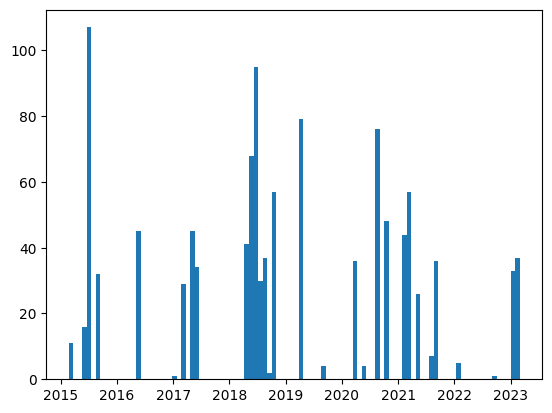

In [7]:
import matplotlib.dates as mdates

data = region_df['datetime']

mpl_data = mdates.date2num(data)

# plot it
fig, ax = plt.subplots(1,1)
ax.hist(mpl_data, bins=100)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

# Merge with weather 

Since this data is not in the proximity of ICOS stations, we need to use the unmatched data, which has to be merged with weather.

The result is saved as "data/lund_with_weather.feather". Once such a file is created, this section can be skipped 

In [9]:
def yearmonth2string(y, m, at_start):
    if at_start: m -= 1
    else: m += 1

    year = str(y)
    month = str(m)

    if len(month) == 1: month = "0" + month
    
    if at_start:
        return year + "-" + month + "-99 99:99:99"
    return year + "-" + month + "-00 00:00:00"

df = region_df

dates = df['datetime']#pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')


In [ ]:
if True:
    print(df.shape)

    timefomat = '%Y-%m-%d %H:%M:%S'

    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    date_path = lambda yr, mth: "data/raw/era5/era5_" + str(yr) + "_" + months[int(mth) - 1] + "_Europe.nc"


    year = 2014
    month = 1

    while True:
        print(" ")
        print("Doing", str(year), months[int(month) - 1])

        if year > 2024: break

        dates = df['datetime']
        n_points = sum((dates > yearmonth2string(year, month, True)) & (dates < yearmonth2string(year, month, False)))
        if n_points == 0:
            print("No points this period -- skipping")
            month += 1
            if month > 12: 
                month = 1
                year += 1
            continue
        else:
            print(n_points, "points found")

        # Load weather data
        print("Loading weather")
        wdf = xr.open_dataset(date_path(year, month)).to_dataframe().reset_index()

        xmin, ymin, xmax, ymax = commune_df.total_bounds
        filtr = (wdf['longitude'] >= np.floor(xmin*4)/4) & (wdf['longitude'] <= np.ceil(xmax*4)/4) & (wdf['latitude'] >= np.floor(ymin*4)/4) & (wdf['latitude'] <= np.ceil(ymax*4)/4)
        wdf = wdf[filtr]


        # Filter only relevant parts of data frame
        print("Getting range")
        lat_range = (min(wdf['latitude']), max(wdf['latitude']))
        lon_range = (min(wdf['longitude']), max(wdf['longitude']))
        time_range = (min(wdf['time']), max(wdf['time']))

        print("Filter dataframe")
        dates = df['datetime']#pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
        df18 = df[(dates > time_range[0].strftime(timefomat)) & (dates < time_range[1].strftime(timefomat))]
        df18 = df18[(lat_range[0] < df18['lat']) & (df18['lat'] < lat_range[1])]
        df18 = df18[(lon_range[0] < df18['lon']) & (df18['lon'] < lon_range[1])]
        df18

        # Get closest dates
        print("Find Nearest weather")
        mn_lat = min(wdf['latitude'])
        lat = np.round((df18['lat'] - mn_lat)*4)/4 + mn_lat
        mn_lon = min(wdf['longitude'])
        lon = np.round((df18['lon'] - mn_lon)*4)/4 + mn_lon
        dates = pd.to_datetime(df18['datetime'], format="%Y-%m-%d %H:%M:%S")
        date = dates.dt.round("H").dt.strftime("%Y-%m-%d %H:%M:%S")

        masks = {'latitude': {}, 'longitude': {}, 'time': {}}
        cols = [d for d in wdf.columns if d not in ["longitude", "latitude", "time"]]

        def get_mask(kind, key):
            if key in masks[kind]: return masks[kind][key]
            mask = wdf[kind] == key
            masks[kind][key] = mask
            return mask

        for idx in tqdm(df18.index):
            mini_df = wdf.loc[get_mask('latitude', lat.loc[idx]) & get_mask('longitude', lon.loc[idx]) & get_mask('time', date.loc[idx])]
            df18.loc[idx, cols] = mini_df.loc[:, cols].values

        print("Saving data")
        df.loc[df18.index, df18.columns] = df18

        df.to_feather("data/" + save_name)

        month += 1
        if month > 12: 
            month = 1
            year += 1

# Load Model
Make predictions on the new OCO observations over Lund

In [15]:
#region_data = region_df
region_data = pd.read_feather("data/" + save_name)
region_data = region_data[np.isnan(region_data['t2m']) == False]
region_data = region_data.rename({"xco2": "OCO2"}, axis=1)
region_data = region_data[region_data['datetime'] > "2015-08-00 00:00:00"]

main_data = pd.read_feather("data/merged_with_weather.feather")
main_data = main_data[np.isnan(main_data['t2m']) == False]
main_data = main_data[list(main_data.columns[2:12]) + list(main_data.columns[20:])]



In [13]:
prohibited = ["ICOS", "time_stamp", "level_0", "index", "datetime", "value_std_dev", "station_dist", "station_lat", "station_lon", "geometry"]# + ["lat", "lon", "hours_since_2014_1_1"]
predictors = ["lat", "lon", 'OCO2', "hours_since_2014_1_1", 't2m', 'd2m', 'tp', 'swvl1', 'sp', 'u10', 'v10', 'cape', 'skt', 'tcc']
target = "ICOS"
test_stations = ['station_KRE', 'station_SVB', 'station_HEL', 'station_TRN']

print(predictors, "->",  target)

['lat', 'lon', 'OCO2', 'hours_since_2014_1_1', 't2m', 'd2m', 'tp', 'swvl1', 'sp', 'u10', 'v10', 'cape', 'skt', 'tcc'] -> ICOS


In [17]:

train_model = False
date = "2024-06-27 09.37.02"

filtr = sum(main_data[s] for s in test_stations) > 0
train = main_data[filtr == False]
test = main_data[filtr == True]
print(predictors, "->", target)

Xt = train[predictors]
yt = train[target]
Xv = test[predictors]
yv = test[target]

mX = np.mean(Xt, axis=0)
sX = np.std(Xt, axis=0)
sX[sX == 0] = 1
Xt = (Xt-mX)/sX
Xv = (Xv-mX)/sX

my = np.mean(yt)
sy = np.std(yt)
yt = (yt-my)/sy
yv = (yv-my)/sy

# load model from specific date
with open("results/config_" + date + ".json") as f:
    previous_result = json.load(f)
config = previous_result['Neural Network Regression']

model = tf.keras.models.load_model("models/refined_full_model_" + date + ".keras")


['lat', 'lon', 'OCO2', 'hours_since_2014_1_1', 't2m', 'd2m', 'tp', 'swvl1', 'sp', 'u10', 'v10', 'cape', 'skt', 'tcc'] -> ICOS


2024-09-06 15:40:52.373222: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/oskar/Documents/Jupyter/CO2/.conda/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


# Predict Ground-Level CO2 on OCO measurements

In [19]:
neu_pred = model.predict((region_data[predictors]-mX)/sX)
neu_pred = neu_pred*sy + my

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


In [20]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,300 (153.52 KB)

 Trainable params: 19,649 (76.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,651 (76.77 KB)

# Generate Heat map

In [23]:
import folium
import branca.colormap as cm

colormap = cm.LinearColormap(["green", "yellow", "red"], vmin = min(neu_pred), vmax=max(neu_pred))
neu_err = neu_pred.reshape(-1).shape - region_data['OCO2'].values

bounds = commune_df['geometry'].total_bounds

# Create a folium map centered at the bounding box
m = folium.Map(location=[(bounds[1] + bounds[3])/2, (bounds[0] + bounds[2])/2], zoom_start=region_zoom)
#m.fit_bounds(bounds)


DIM = 100000000
N = 3


#0/0

for i in range(region_data.shape[0]):
    #if not (test_lund['datetime'].iloc[i] > "2020-00-00 00:00:00") or not (test_lund['datetime'].iloc[i] < "2025-00-00 00:00:00"):  continue
    lat = region_data['lat'].iloc[i]
    lon = region_data['lon'].iloc[i]
    oco2 = region_data['OCO2'].iloc[i]
    neu_p = neu_pred[i]

    folium.CircleMarker([lat, lon], radius=0.5, color=colormap(neu_p)).add_to(m)

for _, r in commune_df.iterrows():
    pass# Without simplifying the representation of each borough,
    # the map might not be displayed
    #sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    #geo_j = sim_geo.to_json()
    #geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    #folium.Popup(r["regso"]).add_to(geo_j)
    #geo_j.add_to(m)

# Display the map
#m.save('bounding_box_map.html')
display(m)

In [24]:
year_plots = {}

### Yearly Predictions

In [29]:

xmin, ymin, xmax, ymax = commune_df.total_bounds
total_pixels = 10000
R = 6371e3; # metres radius of earth

def globe_dist(lat1, lat2, lon1, lon2):
    lat1 *= np.pi/180
    lat2 *= np.pi/180
    lon1 *= np.pi/180
    lon2 *= np.pi/180
    a = (np.sin((lat2 - lat1)/2) ** 2) + (np.cos(lat1) * np.cos(lat2)) * (np.sin((lon2 - lon1)/2) ** 2)
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


width = globe_dist((ymin+ymax)/2, (ymin+ymax)/2, xmin, xmax)
height = globe_dist(ymin, ymax, (xmin+xmax)/2, (xmin+xmax)/2)
aspect = width/height
img_size_y = np.sqrt(total_pixels/aspect)
img_size_x = img_size_y*aspect
img_size_x = int(img_size_x)
img_size_y = int(img_size_y)

for year in range(2015, 2023):
    chosen_year = str(year)
    print(chosen_year)
    year_indices = (region_data['datetime'] > chosen_year + '-00-00') & (region_data['datetime'] < str(int(chosen_year) + 1) + '-00-00')
    year_data = region_data[year_indices]



    lon_range = np.linspace(xmin, xmax, img_size_x, endpoint=False)
    d_lon = (lon_range[1]-lon_range[0])
    lon_range += d_lon/2
    lat_range = np.linspace(ymin, ymax, img_size_y, endpoint=False)
    d_lat = (lat_range[1]-lat_range[0])
    lat_range += d_lat/2
    pred_img = np.zeros((img_size_x, img_size_y))


    region_lat = year_data['lat'] * np.pi/180
    region_lon = year_data['lon'] * np.pi/180
    indices = []
    img_lon = np.zeros((1, img_size_x*img_size_y))
    img_lat = np.zeros((1, img_size_x*img_size_y))
    idx = 0
    for x, lon in enumerate(lon_range):
        for y, lat in enumerate(lat_range):
            img_lon[0, idx] = lon * np.pi/180
            img_lat[0, idx] = lat * np.pi/180
            indices.append((x, y, idx))
            idx += 1


    r_lat = np.zeros((len(region_lat.values), 1))
    r_lon = np.zeros((len(region_lon.values), 1))
    r_lat[:, 0] = region_lat.values
    r_lon[:, 0] = region_lon.values
    Δφ = r_lat - img_lat
    Δλ = r_lon - img_lon
    a = (np.sin(Δφ/2) ** 2) + (np.cos(img_lat) * np.cos(r_lat)) * (np.sin(Δλ/2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c; # in metres
    print(Δφ.shape, Δλ.shape, d.shape) 

    test_df = pd.DataFrame({'lat': img_lat[0, :] * 180/np.pi, 'lon': img_lon[0, :] * 180/np.pi})
    test_df = gpd.GeoDataFrame(
        test_df, geometry=gpd.points_from_xy(test_df["lon"], test_df['lat'])
    )

    commune_filter = test_df.within(commune_df.loc[0, 'geometry'])
    for idx in tqdm(commune_df.index):
        commune_filter |= test_df.within(commune_df.loc[idx, 'geometry'])
    np.mean(commune_filter)

    d_thresh = 2000000000000
    for x, y, i in indices:
        dist = d[:, i]
        p = neu_pred[year_indices, 0]
        if len(p) == 0 or commune_filter[i] == False: pred_img[x,y] = np.nan
        else: 
            s = (1/dist)**0.05#np.exp(-(dist/25000)**2)#(1/dist)**0.5#np.sqrt(1/dist)#
            pred_img[x,y] = np.sum((s * p))/np.sum(s)
    print("accepted", str(round(np.mean(np.isnan(pred_img) == False)*100)) + "%")

    year_plots[chosen_year] = pred_img

2015
(32, 9991) (32, 9991) (32, 9991)


100%|██████████| 36/36 [00:01<00:00, 26.50it/s]


accepted 46%
2016
(45, 9991) (45, 9991) (45, 9991)


100%|██████████| 36/36 [00:01<00:00, 29.30it/s]


accepted 46%
2017
(109, 9991) (109, 9991) (109, 9991)


100%|██████████| 36/36 [00:01<00:00, 27.78it/s]


accepted 46%
2018
(330, 9991) (330, 9991) (330, 9991)


100%|██████████| 36/36 [00:01<00:00, 28.06it/s]


accepted 46%
2019
(83, 9991) (83, 9991) (83, 9991)


100%|██████████| 36/36 [00:01<00:00, 28.44it/s]


accepted 46%
2020
(164, 9991) (164, 9991) (164, 9991)


100%|██████████| 36/36 [00:01<00:00, 29.22it/s]


accepted 46%
2021
(170, 9991) (170, 9991) (170, 9991)


100%|██████████| 36/36 [00:01<00:00, 28.62it/s]


accepted 46%
2022
(6, 9991) (6, 9991) (6, 9991)


100%|██████████| 36/36 [00:01<00:00, 28.65it/s]


accepted 46%


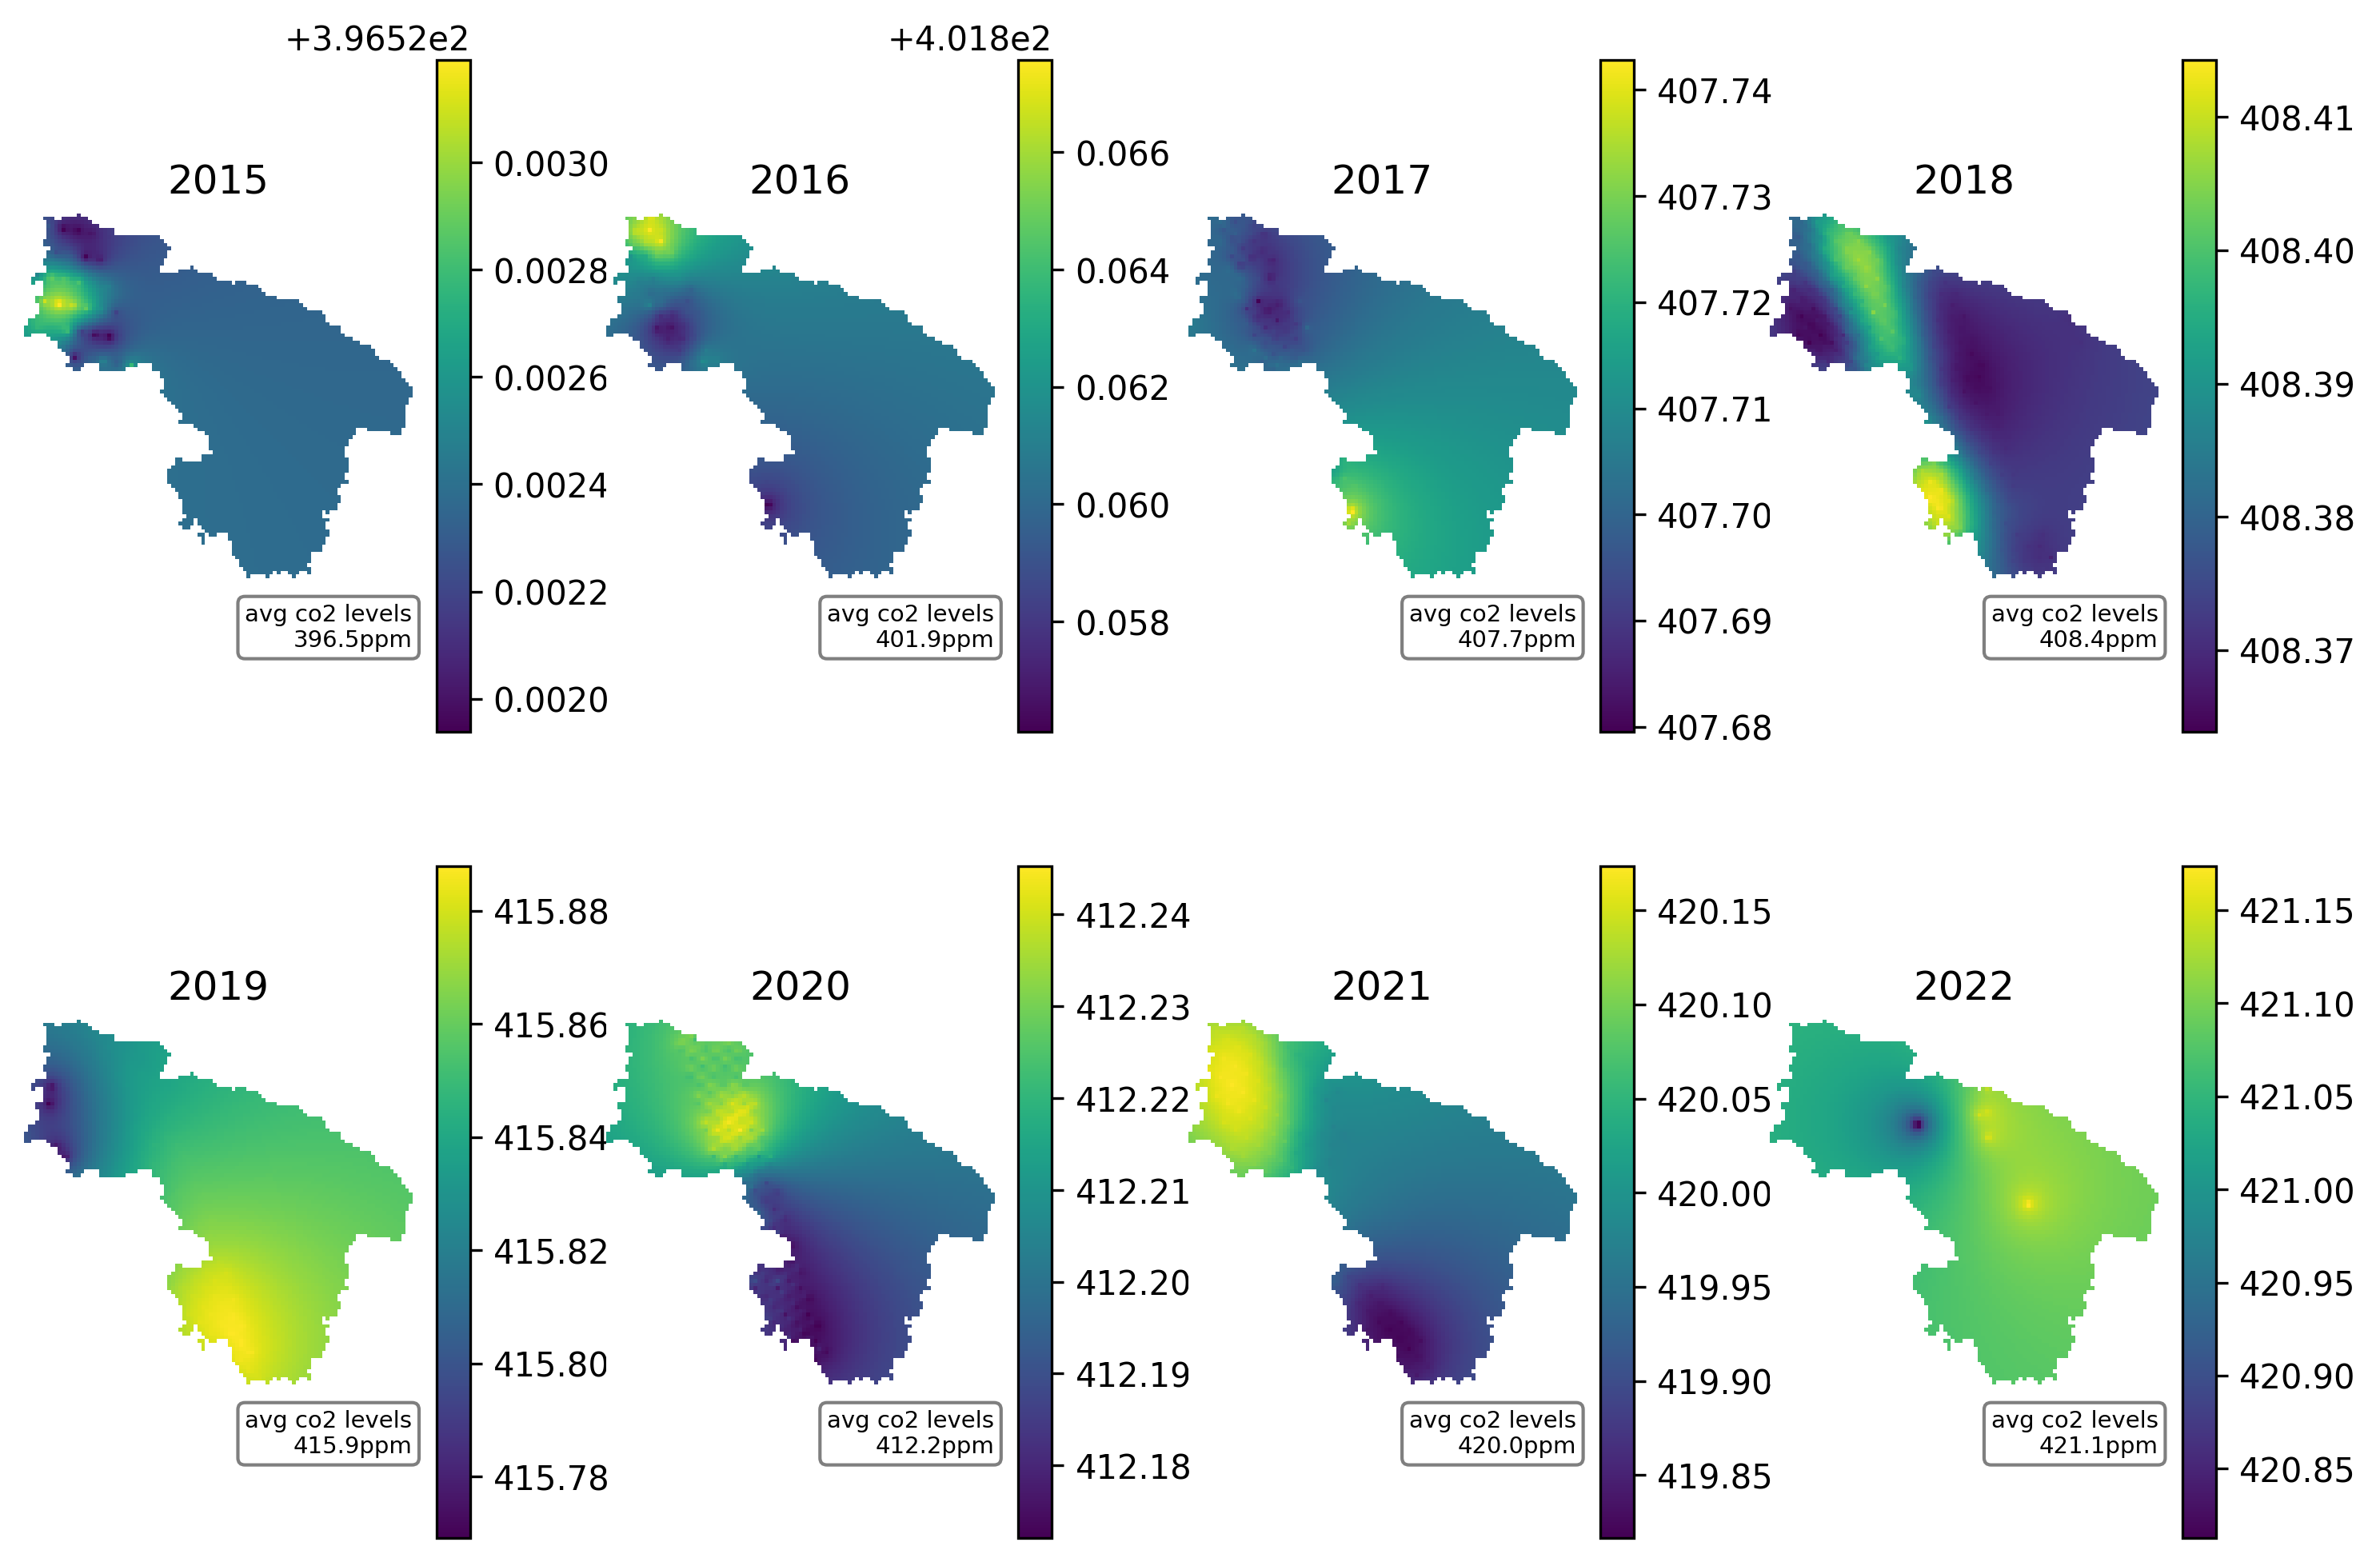

In [26]:
plt.figure(figsize=(12,8), dpi=300)
vmin = 100000
vmax = 0
for year in range(2015, 2023):
    year = str(year)
    vmin = min(vmin, np.nanmin(year_plots[year]))
    vmax = max(vmax, np.nanmax(year_plots[year]))

subplot_index = 1
for year in range(2015, 2023):
    year = str(year)
    pred_img = year_plots[year]
    ax = plt.subplot(2,4,subplot_index)
    subplot_index += 1
    plt.imshow(np.flip(pred_img.transpose(), axis=0))
    #plt.clim([vmin, vmax])
    plt.colorbar()

    textstr = "avg co2 levels\n" + str(round(np.nanmean(pred_img),1)) + "ppm"
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(1, -0.2, textstr, transform=ax.transAxes, fontsize=7, verticalalignment='bottom', horizontalalignment='right', bbox=props)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    plt.title(year)


### Total Prediction

(1009, 9991) (1009, 9991) (1009, 9991)


100%|██████████| 36/36 [00:01<00:00, 29.12it/s]


accepted 46%


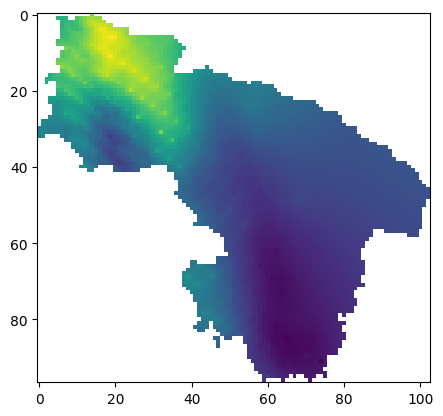

In [30]:

xmin, ymin, xmax, ymax = commune_df.total_bounds
total_pixels = 10000
R = 6371e3; # metres radius of earth

def globe_dist(lat1, lat2, lon1, lon2):
    lat1 *= np.pi/180
    lat2 *= np.pi/180
    lon1 *= np.pi/180
    lon2 *= np.pi/180
    a = (np.sin((lat2 - lat1)/2) ** 2) + (np.cos(lat1) * np.cos(lat2)) * (np.sin((lon2 - lon1)/2) ** 2)
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


width = globe_dist((ymin+ymax)/2, (ymin+ymax)/2, xmin, xmax)
height = globe_dist(ymin, ymax, (xmin+xmax)/2, (xmin+xmax)/2)
aspect = width/height
img_size_y = np.sqrt(total_pixels/aspect)
img_size_x = img_size_y*aspect
img_size_x = int(img_size_x)
img_size_y = int(img_size_y)

lon_range = np.linspace(xmin, xmax, img_size_x, endpoint=False)
d_lon = (lon_range[1]-lon_range[0])
lon_range += d_lon/2
lat_range = np.linspace(ymin, ymax, img_size_y, endpoint=False)
d_lat = (lat_range[1]-lat_range[0])
lat_range += d_lat/2
pred_img = np.zeros((img_size_x, img_size_y))


region_lat = region_data['lat'] * np.pi/180
region_lon = region_data['lon'] * np.pi/180
indices = []
img_lon = np.zeros((1, img_size_x*img_size_y))
img_lat = np.zeros((1, img_size_x*img_size_y))
idx = 0
for x, lon in enumerate(lon_range):
    for y, lat in enumerate(lat_range):
        img_lon[0, idx] = lon * np.pi/180
        img_lat[0, idx] = lat * np.pi/180
        indices.append((x, y, idx))
        idx += 1


r_lat = np.zeros((len(region_lat.values), 1))
r_lon = np.zeros((len(region_lon.values), 1))
r_lat[:, 0] = region_lat.values
r_lon[:, 0] = region_lon.values
Δφ = r_lat - img_lat
Δλ = r_lon - img_lon
a = (np.sin(Δφ/2) ** 2) + (np.cos(img_lat) * np.cos(r_lat)) * (np.sin(Δλ/2) ** 2)
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
d = R * c; # in metres
print(Δφ.shape, Δλ.shape, d.shape) 

test_df = pd.DataFrame({'lat': img_lat[0, :] * 180/np.pi, 'lon': img_lon[0, :] * 180/np.pi})
test_df = gpd.GeoDataFrame(
    test_df, geometry=gpd.points_from_xy(test_df["lon"], test_df['lat'])
)

commune_filter = test_df.within(commune_df.loc[0, 'geometry'])
for idx in tqdm(commune_df.index):
    commune_filter |= test_df.within(commune_df.loc[idx, 'geometry'])
np.mean(commune_filter)

d_thresh = 2000000000000
for x, y, i in indices:
    dist = d[:, i]
    p = neu_pred[:, 0]
    if len(p) == 0 or commune_filter[i] == False: pred_img[x,y] = np.nan
    else: 
        s = (1/dist)**0.05#np.exp(-(dist/25000)**2)#(1/dist)**0.5#np.sqrt(1/dist)#
        pred_img[x,y] = np.sum((s * p))/np.sum(s)
print("accepted", str(round(np.mean(np.isnan(pred_img) == False)*100)) + "%")

plt.imshow(np.flip(pred_img.transpose(), axis=0))

# Show on map

In [32]:

# Create a folium map centered at the bounding box
vmin = np.nanmin(pred_img)
vmax = np.nanmax(pred_img)
colormap = cm.LinearColormap(["green", "yellow", "red"], vmin=vmin, vmax=vmax)
m = folium.Map(location=[(ymin + ymax)/2, (xmin+xmax)/2], zoom_start=region_zoom)
#m.fit_bounds(bounds)


DIM = 100000000
N = 3


#0/0

folium.CircleMarker([ymin, xmin], radius=0.5, color="blue").add_to(m)

for x, lon in enumerate(lon_range):
    for y, lat in enumerate(lat_range):
        if np.isnan(pred_img[x,y]): continue
        folium.CircleMarker([lat, lon], radius=0.5, color=colormap(pred_img[x,y])).add_to(m)

for _, r in commune_df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["regso"]).add_to(geo_j)
    geo_j.add_to(m)

# Display the map
#m.save('bounding_box_map.html')
display(m)

In [34]:
image = pred_img
image[np.isnan(image)] = 0

print("co2 range: ", vmin, vmax)

m = folium.Map(location=[(ymin + ymax)/2, (xmin+xmax)/2], zoom_start=region_zoom)

if False:
    folium.raster_layers.ImageOverlay(
        image = 1 - (np.flip(pred_img, axis=1).transpose()-vmin)/(vmax - vmin),
        bounds=[[ymin,xmin], [ymax,xmax]],
        #origin="lower",
        colormap=lambda x: (1, x*2, 0, (x < 1)) if x < 0.5 else (1-(x-0.5)*2, 1, 0, (x < 1)),
        opacity=.5
    ).add_to(m)

for x, lon in enumerate(lon_range):
    for y, lat in enumerate(lat_range):
        if pred_img[x,y] == 0: continue
        clr = colormap(pred_img[x,y])
        folium.Rectangle(bounds=[(lat-d_lat/2, lon-d_lon/2), (lat+d_lat/2, lon+d_lon/2)], color="none",
            fill=True, fill_color=clr, fill_opacity=0.5
        ).add_to(m)




if False:

    for x, lon in enumerate(lon_range):
        for y, lat in enumerate(lat_range):
            if pred_img[x,y] == 0: continue
            clr = colormap(pred_img[x,y])
            clr = 'black'
            folium.CircleMarker([lat, lon], radius=0.5, color=clr).add_to(m)

    for _, r in commune_df.iterrows():
        if np.random.rand() > 0.5: continue
        # Without simplifying the representation of each borough,
        # the map might not be displayed
        sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.00001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"color": "black", "fillColor": "orange"})
        folium.Popup(r["regso"]).add_to(geo_j)
        geo_j.add_to(m)

m

co2 range:  412.5011051984305 412.5473710785606
